# Basic time series exploration

In [19]:
from time_series_expenses.prepare_data import monthly

## Creating a Prophet model

In [20]:
monthly.head()

,y,ds,floor,cap
Date,,,,
2021-10-01,659.76,2021-10-01,0,10000
2021-11-01,840.82,2021-11-01,0,10000
2021-12-01,378.26,2021-12-01,0,10000
2022-01-01,825.94,2022-01-01,0,10000
2022-02-01,551.60,2022-02-01,0,10000


In [21]:
from prophet import Prophet
model = Prophet()

model.fit(monthly)

14:30:02 - cmdstanpy - INFO - Chain [1] start processing
14:30:02 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# Predict next year
future = model.make_future_dataframe(periods = 12, freq = "MS")
forecast = model.predict(future)[["ds", "yhat", "yhat_lower", "yhat_upper"]]

forecast.tail(13)

,ds,yhat,yhat_lower,yhat_upper
29,2024-03-01,952.140845,712.153964,1178.516689
30,2024-04-01,1028.470628,766.915342,1271.695530
31,2024-05-01,1599.482397,1357.711977,1829.090503
32,2024-06-01,147.252904,-104.093697,371.609251
33,2024-07-01,1856.977252,1605.651147,2094.016638
34,2024-08-01,2533.920093,2285.229351,2763.697170
35,2024-09-01,1278.637344,1026.326087,1512.274446
36,2024-10-01,1686.821793,1437.558228,1928.436769
37,2024-11-01,906.759824,650.510874,1148.277357
38,2024-12-01,1415.911314,1173.825789,1658.132208


c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



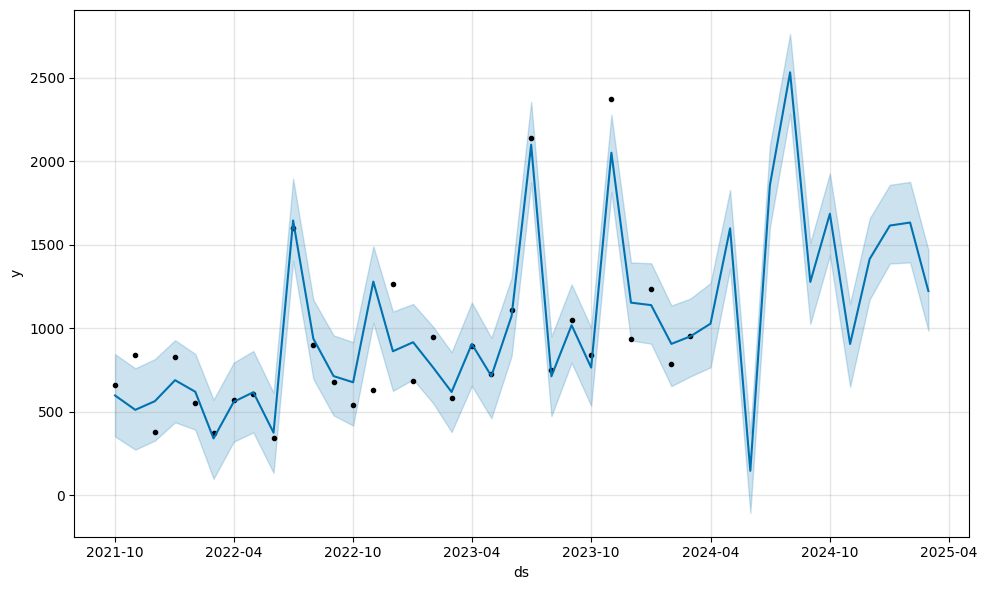

In [23]:
# Automatic plotting of a given dataframe
figure1 = model.plot(forecast)

## Metrics

In [24]:
from time_series_expenses.forecast_metrics import create_metrics_df
original_metrics = create_metrics_df(monthly, forecast)

In [25]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(r2_score(original_metrics.y, original_metrics.yhat))
print(mean_squared_error(original_metrics.y, original_metrics.yhat))
print(f"MAE: {mean_absolute_error(original_metrics.y, original_metrics.yhat)}")


0.8312310851033843
35071.712239610824
MAE: 120.55250166282562


In [26]:
# Interactive plot
# For monthly data, 1month and 1week, components in general not available
from prophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast)

Saturating forecasts - minimums and maximums

In [27]:
# We need to add an additional column to the dataframe - cap for maximum, floor for minimum, and pass that to the model
monthly["floor"] = 0

# A cap is NEEDED, not optional. Floor is optional.

# Arbitrarily high cap:
monthly["cap"] = 10000
monthly.tail()

,y,ds,floor,cap
Date,,,,
2023-11-01,2373.00,2023-11-01,0,10000
2023-12-01,937.80,2023-12-01,0,10000
2024-01-01,1235.74,2024-01-01,0,10000
2024-02-01,789.50,2024-02-01,0,10000
2024-03-01,952.70,2024-03-01,0,10000


In [28]:
model_logistic = Prophet(growth = "logistic")
model_logistic.fit(monthly)

14:30:03 - cmdstanpy - INFO - Chain [1] start processing
14:30:03 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
future = model_logistic.make_future_dataframe(periods = 12, freq = "MS")
future["cap"] = 10000
future["floor"] = 0
future.tail()

,ds,cap,floor
37,2024-11-01,10000,0
38,2024-12-01,10000,0
39,2025-01-01,10000,0
40,2025-02-01,10000,0
41,2025-03-01,10000,0


c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



(0.0, 3000.0)

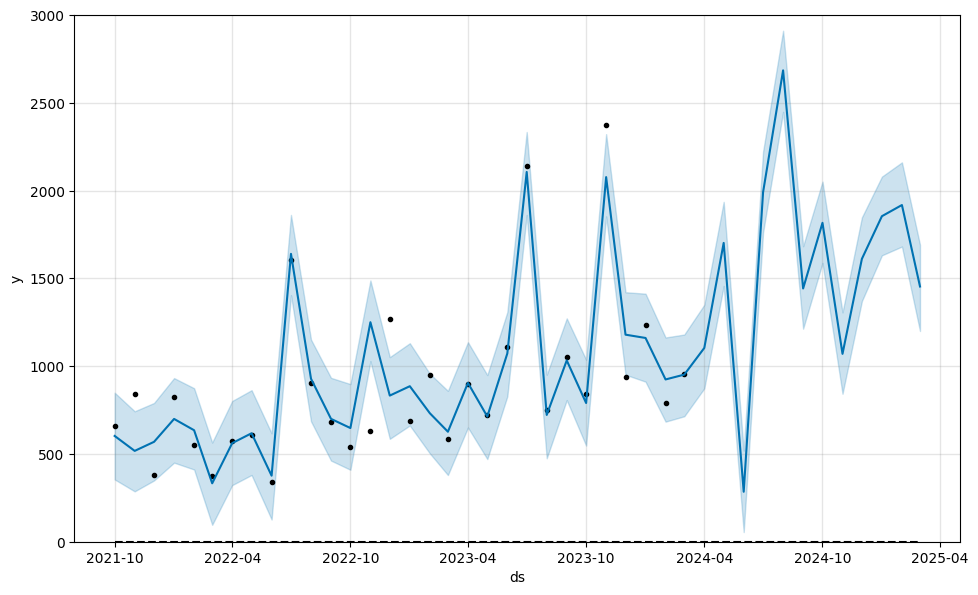

In [30]:
forecast2 = model_logistic.predict(future)
fig_logistic = model_logistic.plot(forecast2)

# Set the axis to not stretch to 10000
axes = fig_logistic.gca()
axes.set_ylim([0, 3000])

## Cross validation

In [31]:
monthly_model = Prophet(yearly_seasonality= True, weekly_seasonality= False, daily_seasonality=False)
# Info for monthly seasonality: https://stackoverflow.com/a/71810822/21445669
monthly_model.add_seasonality(
    name = "monthly",
    period = 30.5,
    fourier_order= 5
)
monthly_model.fit(monthly)

14:30:03 - cmdstanpy - INFO - Chain [1] start processing
14:30:03 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# Predict next year
future = monthly_model.make_future_dataframe(periods = 12, freq = "MS")
forecast = monthly_model.predict(future)[["ds", "yhat", "yhat_lower", "yhat_upper"]]

forecast.tail(13)

,ds,yhat,yhat_lower,yhat_upper
29,2024-03-01,956.337524,760.991212,1154.991811
30,2024-04-01,2436.708479,2245.553473,2639.070965
31,2024-05-01,1386.028316,1159.612813,1585.786853
32,2024-06-01,1216.527989,1019.483574,1419.713904
33,2024-07-01,1287.025440,1092.563173,1484.217400
34,2024-08-01,3333.430511,3151.670560,3537.443448
35,2024-09-01,2153.353838,1959.006911,2353.789458
36,2024-10-01,2324.469344,2116.681731,2524.516176
37,2024-11-01,1214.924548,1034.814379,1416.294231
38,2024-12-01,2111.664311,1912.472091,2308.990997


c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Projekti_programiranje\Python\Python projects\ML_in_Python\time_series_expenses\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



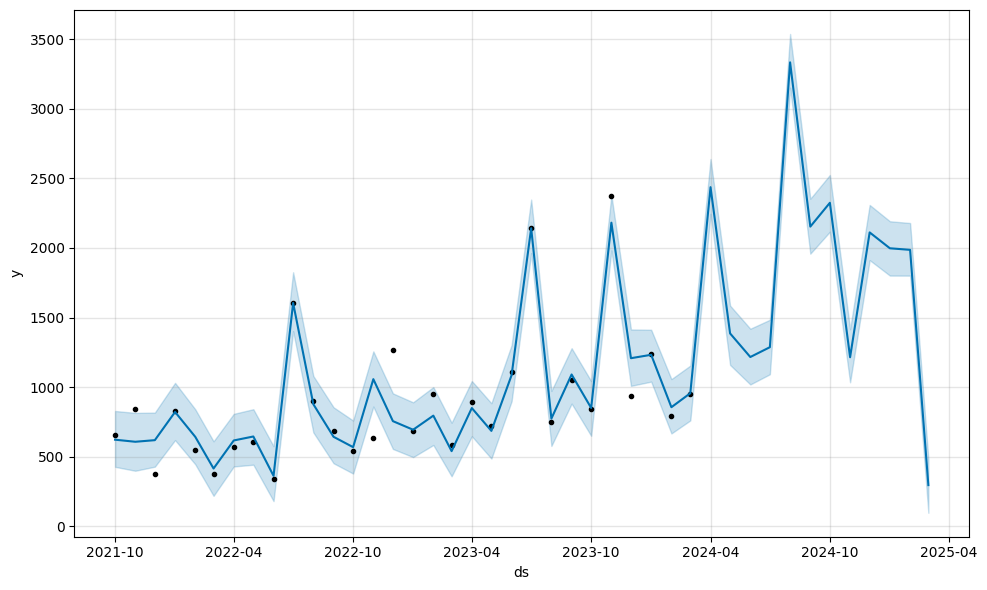

In [33]:
# Automatic plotting of a given dataframe
figure2 = monthly_model.plot(forecast)

In [34]:
metrics_df = create_metrics_df(monthly, forecast)

metrics_df.head()

,yhat,y
ds,,
2021-10-01,622.551653,659.76
2021-11-01,607.686198,840.82
2021-12-01,619.206352,378.26
2022-01-01,821.770109,825.94
2022-02-01,642.944763,551.60


In [35]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

print(r2_score(metrics_df.y, metrics_df.yhat))
print(mean_squared_error(metrics_df.y, metrics_df.yhat))
print(f"MAE: {mean_absolute_error(metrics_df.y, metrics_df.yhat)}")


0.8847150003149764
23957.269245782478
MAE: 90.22034537211695
